# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

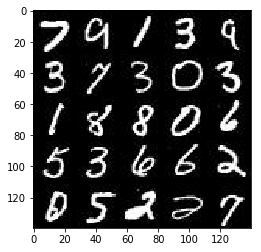

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

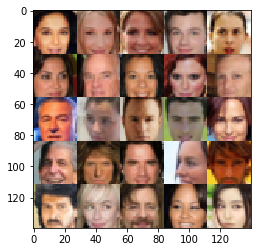

In [6]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_size = (image_width, image_height, image_channels)
    inputs_real = tf.placeholder(tf.float32, (None, *real_size), name='input_real')
    inputs_z =  tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='l_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2=  tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256 , 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
# def generator(z, out_channel_dim, is_train=True):
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = not is_train
    with tf.variable_scope("generator", reuse=reuse):
        # First fully generator layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x64 now
        
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same')
        # 28x28xout_channel_dim now
        
        out = tf.tanh(logits)
        
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    smooth = 0.1
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model    
    # Create our input placeholders
    input_real, input_z, l_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    # loss
    out_channel_dim = data_shape[3]
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    
    # optimization
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, l_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # since we are using tanh output on the generator, 
                # images from the generator are scaled from -1 to +1, 
                # so we need to scale our images from a range of (-0.5, 0.5) to a range of (-1, +1)
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, l_rate: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, l_rate: learning_rate})

                if steps % 10 == 0:
                    # After each 100 batches, get the losses and print them out
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g)) 
                    
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, out_channel_dim, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.1577... Generator Loss: 5.2166
Epoch 1/2... Discriminator Loss: 0.5434... Generator Loss: 2.0222
Epoch 1/2... Discriminator Loss: 1.4483... Generator Loss: 0.5658
Epoch 1/2... Discriminator Loss: 2.4943... Generator Loss: 3.9738
Epoch 1/2... Discriminator Loss: 1.3487... Generator Loss: 0.6698
Epoch 1/2... Discriminator Loss: 1.1527... Generator Loss: 1.1433
Epoch 1/2... Discriminator Loss: 1.3660... Generator Loss: 0.5659
Epoch 1/2... Discriminator Loss: 1.1333... Generator Loss: 1.0776
Epoch 1/2... Discriminator Loss: 1.1269... Generator Loss: 1.2448
Epoch 1/2... Discriminator Loss: 1.2769... Generator Loss: 0.6917


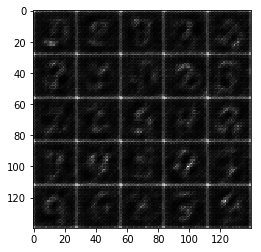

Epoch 1/2... Discriminator Loss: 1.1276... Generator Loss: 1.2996
Epoch 1/2... Discriminator Loss: 1.1795... Generator Loss: 1.1987
Epoch 1/2... Discriminator Loss: 1.5356... Generator Loss: 0.4406
Epoch 1/2... Discriminator Loss: 1.1322... Generator Loss: 1.5650
Epoch 1/2... Discriminator Loss: 1.1158... Generator Loss: 0.9955
Epoch 1/2... Discriminator Loss: 1.3866... Generator Loss: 1.8063
Epoch 1/2... Discriminator Loss: 1.0150... Generator Loss: 1.4539
Epoch 1/2... Discriminator Loss: 0.9441... Generator Loss: 1.7332
Epoch 1/2... Discriminator Loss: 1.2919... Generator Loss: 0.5759
Epoch 1/2... Discriminator Loss: 1.0162... Generator Loss: 0.8541


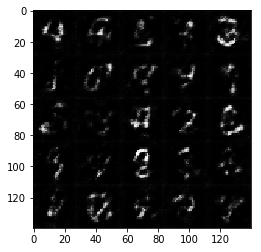

Epoch 1/2... Discriminator Loss: 1.0179... Generator Loss: 0.9936
Epoch 1/2... Discriminator Loss: 0.9616... Generator Loss: 1.6220
Epoch 1/2... Discriminator Loss: 1.0414... Generator Loss: 0.8635
Epoch 1/2... Discriminator Loss: 0.8472... Generator Loss: 1.6444
Epoch 1/2... Discriminator Loss: 1.2139... Generator Loss: 0.6261
Epoch 1/2... Discriminator Loss: 0.8443... Generator Loss: 1.4217
Epoch 1/2... Discriminator Loss: 0.9710... Generator Loss: 2.4442
Epoch 1/2... Discriminator Loss: 1.1251... Generator Loss: 1.8717
Epoch 1/2... Discriminator Loss: 0.9456... Generator Loss: 0.9488
Epoch 1/2... Discriminator Loss: 0.9079... Generator Loss: 1.1081


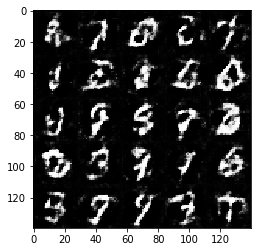

Epoch 1/2... Discriminator Loss: 1.0277... Generator Loss: 1.0140
Epoch 1/2... Discriminator Loss: 1.0032... Generator Loss: 2.1381
Epoch 1/2... Discriminator Loss: 1.3490... Generator Loss: 0.5252
Epoch 1/2... Discriminator Loss: 1.1202... Generator Loss: 0.7756
Epoch 1/2... Discriminator Loss: 1.5302... Generator Loss: 0.4088
Epoch 1/2... Discriminator Loss: 0.9782... Generator Loss: 1.1349
Epoch 1/2... Discriminator Loss: 0.9955... Generator Loss: 0.9868
Epoch 1/2... Discriminator Loss: 0.9862... Generator Loss: 1.3280
Epoch 1/2... Discriminator Loss: 1.2074... Generator Loss: 1.4020
Epoch 1/2... Discriminator Loss: 1.2664... Generator Loss: 0.6619


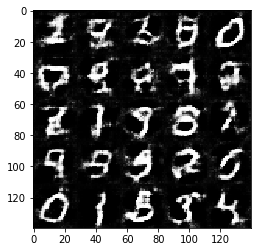

Epoch 1/2... Discriminator Loss: 0.8711... Generator Loss: 1.4674
Epoch 1/2... Discriminator Loss: 1.0976... Generator Loss: 1.7749
Epoch 1/2... Discriminator Loss: 0.9343... Generator Loss: 1.1872
Epoch 1/2... Discriminator Loss: 1.0848... Generator Loss: 1.8842
Epoch 1/2... Discriminator Loss: 0.8648... Generator Loss: 1.2371
Epoch 1/2... Discriminator Loss: 1.1997... Generator Loss: 0.6734
Epoch 1/2... Discriminator Loss: 0.9318... Generator Loss: 1.3819
Epoch 1/2... Discriminator Loss: 1.0627... Generator Loss: 0.8279
Epoch 1/2... Discriminator Loss: 1.0484... Generator Loss: 0.9308
Epoch 1/2... Discriminator Loss: 1.1082... Generator Loss: 0.8075


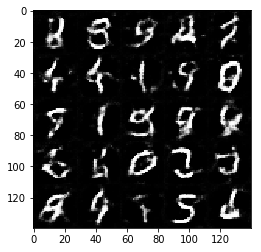

Epoch 1/2... Discriminator Loss: 1.1213... Generator Loss: 0.7036
Epoch 1/2... Discriminator Loss: 1.5169... Generator Loss: 0.4418
Epoch 1/2... Discriminator Loss: 1.2266... Generator Loss: 0.6476
Epoch 1/2... Discriminator Loss: 1.8405... Generator Loss: 0.2966
Epoch 1/2... Discriminator Loss: 1.2329... Generator Loss: 0.6107
Epoch 1/2... Discriminator Loss: 1.2763... Generator Loss: 0.5826
Epoch 1/2... Discriminator Loss: 1.0185... Generator Loss: 1.2313
Epoch 1/2... Discriminator Loss: 1.1133... Generator Loss: 0.8745
Epoch 1/2... Discriminator Loss: 1.1764... Generator Loss: 1.4647
Epoch 1/2... Discriminator Loss: 0.9252... Generator Loss: 1.0887


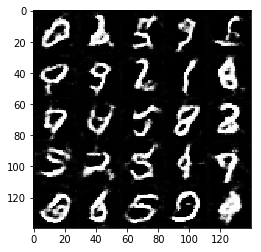

Epoch 1/2... Discriminator Loss: 0.9252... Generator Loss: 1.2388
Epoch 1/2... Discriminator Loss: 0.9398... Generator Loss: 1.0203
Epoch 1/2... Discriminator Loss: 1.0369... Generator Loss: 1.1334
Epoch 1/2... Discriminator Loss: 1.4248... Generator Loss: 0.4655
Epoch 1/2... Discriminator Loss: 1.2755... Generator Loss: 0.5836
Epoch 1/2... Discriminator Loss: 0.9845... Generator Loss: 1.5831
Epoch 1/2... Discriminator Loss: 1.0777... Generator Loss: 0.7473
Epoch 1/2... Discriminator Loss: 1.0192... Generator Loss: 0.9958
Epoch 1/2... Discriminator Loss: 0.9365... Generator Loss: 1.2333
Epoch 1/2... Discriminator Loss: 1.3189... Generator Loss: 1.8675


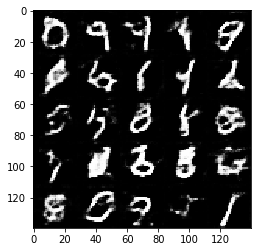

Epoch 1/2... Discriminator Loss: 0.9630... Generator Loss: 1.0359
Epoch 1/2... Discriminator Loss: 1.0325... Generator Loss: 1.0218
Epoch 1/2... Discriminator Loss: 0.8769... Generator Loss: 1.1842
Epoch 1/2... Discriminator Loss: 0.9068... Generator Loss: 1.0807
Epoch 1/2... Discriminator Loss: 1.1628... Generator Loss: 0.7841
Epoch 1/2... Discriminator Loss: 1.0536... Generator Loss: 1.1093
Epoch 1/2... Discriminator Loss: 1.0623... Generator Loss: 0.8581
Epoch 1/2... Discriminator Loss: 0.7781... Generator Loss: 1.3003
Epoch 1/2... Discriminator Loss: 0.9098... Generator Loss: 1.2041
Epoch 1/2... Discriminator Loss: 0.9851... Generator Loss: 0.9311


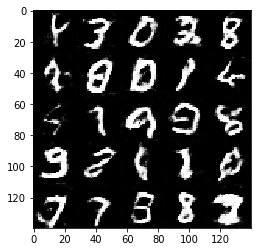

Epoch 1/2... Discriminator Loss: 0.8337... Generator Loss: 1.1610
Epoch 1/2... Discriminator Loss: 0.8828... Generator Loss: 1.1609
Epoch 1/2... Discriminator Loss: 2.7477... Generator Loss: 4.5312
Epoch 1/2... Discriminator Loss: 0.9317... Generator Loss: 1.0296
Epoch 1/2... Discriminator Loss: 0.8327... Generator Loss: 1.1875
Epoch 1/2... Discriminator Loss: 0.9190... Generator Loss: 1.0460
Epoch 1/2... Discriminator Loss: 0.9334... Generator Loss: 1.0089
Epoch 1/2... Discriminator Loss: 0.9490... Generator Loss: 0.9852
Epoch 1/2... Discriminator Loss: 0.8926... Generator Loss: 1.1063
Epoch 1/2... Discriminator Loss: 2.2508... Generator Loss: 3.5716


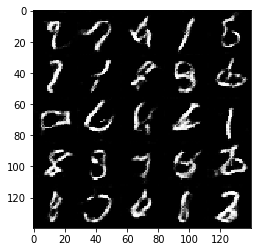

Epoch 1/2... Discriminator Loss: 0.9295... Generator Loss: 1.1027
Epoch 1/2... Discriminator Loss: 1.0906... Generator Loss: 0.7345
Epoch 1/2... Discriminator Loss: 0.9935... Generator Loss: 0.8708
Epoch 2/2... Discriminator Loss: 1.1267... Generator Loss: 0.7855
Epoch 2/2... Discriminator Loss: 1.2633... Generator Loss: 0.6538
Epoch 2/2... Discriminator Loss: 0.7560... Generator Loss: 1.3585
Epoch 2/2... Discriminator Loss: 2.0196... Generator Loss: 0.2792
Epoch 2/2... Discriminator Loss: 0.9139... Generator Loss: 1.0328
Epoch 2/2... Discriminator Loss: 1.0476... Generator Loss: 0.8756
Epoch 2/2... Discriminator Loss: 1.0879... Generator Loss: 0.7410


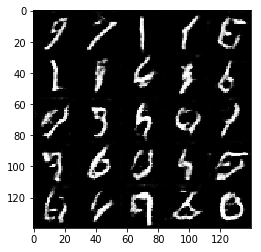

Epoch 2/2... Discriminator Loss: 1.6964... Generator Loss: 2.6911
Epoch 2/2... Discriminator Loss: 1.0409... Generator Loss: 1.0035
Epoch 2/2... Discriminator Loss: 1.0227... Generator Loss: 0.8933
Epoch 2/2... Discriminator Loss: 1.1124... Generator Loss: 0.7361
Epoch 2/2... Discriminator Loss: 1.5203... Generator Loss: 0.5137
Epoch 2/2... Discriminator Loss: 1.4421... Generator Loss: 2.6756
Epoch 2/2... Discriminator Loss: 0.9086... Generator Loss: 1.1355
Epoch 2/2... Discriminator Loss: 1.0623... Generator Loss: 0.7781
Epoch 2/2... Discriminator Loss: 1.1256... Generator Loss: 0.7255
Epoch 2/2... Discriminator Loss: 0.9858... Generator Loss: 0.9224


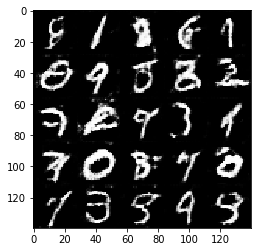

Epoch 2/2... Discriminator Loss: 0.9901... Generator Loss: 0.9671
Epoch 2/2... Discriminator Loss: 0.8768... Generator Loss: 1.1484
Epoch 2/2... Discriminator Loss: 1.4685... Generator Loss: 0.4503
Epoch 2/2... Discriminator Loss: 1.1128... Generator Loss: 2.2515
Epoch 2/2... Discriminator Loss: 1.1034... Generator Loss: 0.7845
Epoch 2/2... Discriminator Loss: 0.8359... Generator Loss: 1.5400
Epoch 2/2... Discriminator Loss: 1.0190... Generator Loss: 0.8273
Epoch 2/2... Discriminator Loss: 2.1013... Generator Loss: 0.2398
Epoch 2/2... Discriminator Loss: 1.0926... Generator Loss: 0.8356
Epoch 2/2... Discriminator Loss: 1.1622... Generator Loss: 1.9407


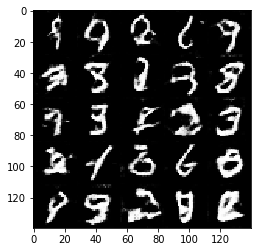

Epoch 2/2... Discriminator Loss: 0.7875... Generator Loss: 1.5408
Epoch 2/2... Discriminator Loss: 1.0689... Generator Loss: 1.4818
Epoch 2/2... Discriminator Loss: 0.8684... Generator Loss: 1.1148
Epoch 2/2... Discriminator Loss: 0.9362... Generator Loss: 1.6975
Epoch 2/2... Discriminator Loss: 1.2279... Generator Loss: 0.6209
Epoch 2/2... Discriminator Loss: 1.5878... Generator Loss: 0.4505
Epoch 2/2... Discriminator Loss: 1.3156... Generator Loss: 0.5444
Epoch 2/2... Discriminator Loss: 0.9168... Generator Loss: 1.0756
Epoch 2/2... Discriminator Loss: 1.1365... Generator Loss: 0.7613
Epoch 2/2... Discriminator Loss: 0.9501... Generator Loss: 0.8972


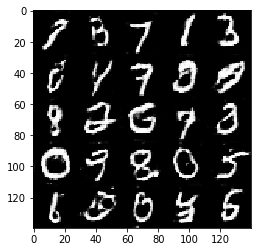

Epoch 2/2... Discriminator Loss: 0.7726... Generator Loss: 1.5257
Epoch 2/2... Discriminator Loss: 0.9917... Generator Loss: 0.8709
Epoch 2/2... Discriminator Loss: 1.0218... Generator Loss: 0.9583
Epoch 2/2... Discriminator Loss: 0.7820... Generator Loss: 1.6979
Epoch 2/2... Discriminator Loss: 0.8678... Generator Loss: 1.8679
Epoch 2/2... Discriminator Loss: 0.9538... Generator Loss: 0.9995
Epoch 2/2... Discriminator Loss: 0.9368... Generator Loss: 1.0772
Epoch 2/2... Discriminator Loss: 1.5078... Generator Loss: 0.5345
Epoch 2/2... Discriminator Loss: 0.8634... Generator Loss: 1.3583
Epoch 2/2... Discriminator Loss: 0.9311... Generator Loss: 1.0746


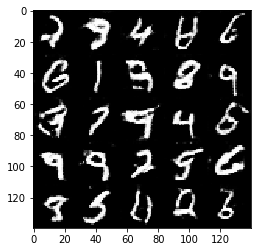

Epoch 2/2... Discriminator Loss: 1.0605... Generator Loss: 2.0868
Epoch 2/2... Discriminator Loss: 0.9887... Generator Loss: 0.9530
Epoch 2/2... Discriminator Loss: 1.0394... Generator Loss: 0.8502
Epoch 2/2... Discriminator Loss: 0.8706... Generator Loss: 1.1274
Epoch 2/2... Discriminator Loss: 1.2406... Generator Loss: 0.6701
Epoch 2/2... Discriminator Loss: 0.6847... Generator Loss: 1.8764
Epoch 2/2... Discriminator Loss: 0.7236... Generator Loss: 1.5290
Epoch 2/2... Discriminator Loss: 0.8522... Generator Loss: 1.2646
Epoch 2/2... Discriminator Loss: 1.0154... Generator Loss: 1.8304
Epoch 2/2... Discriminator Loss: 0.6965... Generator Loss: 2.2281


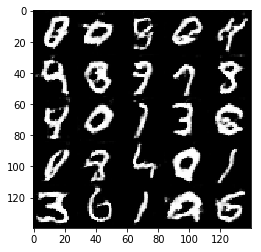

Epoch 2/2... Discriminator Loss: 1.0394... Generator Loss: 1.3241
Epoch 2/2... Discriminator Loss: 0.9482... Generator Loss: 1.4976
Epoch 2/2... Discriminator Loss: 0.9821... Generator Loss: 1.0519
Epoch 2/2... Discriminator Loss: 1.0508... Generator Loss: 0.9539
Epoch 2/2... Discriminator Loss: 0.7147... Generator Loss: 1.8682
Epoch 2/2... Discriminator Loss: 1.3896... Generator Loss: 0.6160
Epoch 2/2... Discriminator Loss: 0.9075... Generator Loss: 1.4762
Epoch 2/2... Discriminator Loss: 0.7438... Generator Loss: 1.3752
Epoch 2/2... Discriminator Loss: 0.8463... Generator Loss: 1.8998
Epoch 2/2... Discriminator Loss: 0.9367... Generator Loss: 2.0936


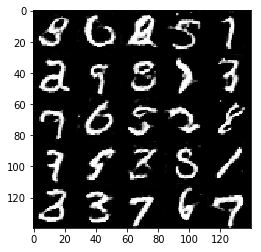

Epoch 2/2... Discriminator Loss: 1.0981... Generator Loss: 0.8022
Epoch 2/2... Discriminator Loss: 1.3302... Generator Loss: 0.5588
Epoch 2/2... Discriminator Loss: 0.9362... Generator Loss: 1.2507
Epoch 2/2... Discriminator Loss: 0.9170... Generator Loss: 1.4438
Epoch 2/2... Discriminator Loss: 1.4034... Generator Loss: 0.6092
Epoch 2/2... Discriminator Loss: 0.9479... Generator Loss: 1.1135
Epoch 2/2... Discriminator Loss: 0.9319... Generator Loss: 0.9523
Epoch 2/2... Discriminator Loss: 0.8273... Generator Loss: 1.1928
Epoch 2/2... Discriminator Loss: 0.8978... Generator Loss: 1.0771
Epoch 2/2... Discriminator Loss: 0.7890... Generator Loss: 1.3583


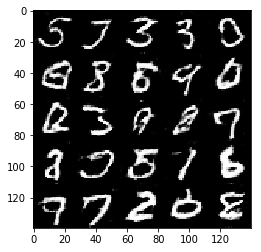

Epoch 2/2... Discriminator Loss: 0.8816... Generator Loss: 1.8857
Epoch 2/2... Discriminator Loss: 0.7883... Generator Loss: 1.6340
Epoch 2/2... Discriminator Loss: 0.8873... Generator Loss: 1.2164
Epoch 2/2... Discriminator Loss: 0.8578... Generator Loss: 1.1387
Epoch 2/2... Discriminator Loss: 0.9335... Generator Loss: 1.0392
Epoch 2/2... Discriminator Loss: 1.0746... Generator Loss: 2.7875
Epoch 2/2... Discriminator Loss: 0.7509... Generator Loss: 1.2810
Epoch 2/2... Discriminator Loss: 0.9892... Generator Loss: 0.9125
Epoch 2/2... Discriminator Loss: 1.1353... Generator Loss: 0.7594
Epoch 2/2... Discriminator Loss: 1.0222... Generator Loss: 0.9821


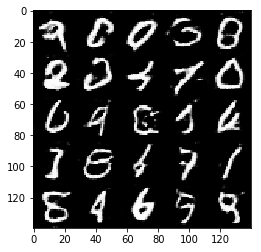

Epoch 2/2... Discriminator Loss: 0.7936... Generator Loss: 1.7766
Epoch 2/2... Discriminator Loss: 1.0968... Generator Loss: 0.7908
Epoch 2/2... Discriminator Loss: 0.7840... Generator Loss: 1.3451
Epoch 2/2... Discriminator Loss: 0.8257... Generator Loss: 1.1243
Epoch 2/2... Discriminator Loss: 1.1987... Generator Loss: 0.6977
Epoch 2/2... Discriminator Loss: 1.2158... Generator Loss: 0.7487
Epoch 2/2... Discriminator Loss: 0.8035... Generator Loss: 1.4054


In [14]:
batch_size = 64
z_dim = 112
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5300... Generator Loss: 2.5349
Epoch 1/1... Discriminator Loss: 0.4705... Generator Loss: 2.8783
Epoch 1/1... Discriminator Loss: 0.3878... Generator Loss: 8.3761
Epoch 1/1... Discriminator Loss: 0.7723... Generator Loss: 8.1885
Epoch 1/1... Discriminator Loss: 0.8440... Generator Loss: 1.8226
Epoch 1/1... Discriminator Loss: 1.9360... Generator Loss: 7.5103
Epoch 1/1... Discriminator Loss: 0.7575... Generator Loss: 2.4010
Epoch 1/1... Discriminator Loss: 0.7259... Generator Loss: 2.4057
Epoch 1/1... Discriminator Loss: 0.9277... Generator Loss: 2.5657
Epoch 1/1... Discriminator Loss: 1.3520... Generator Loss: 0.5692


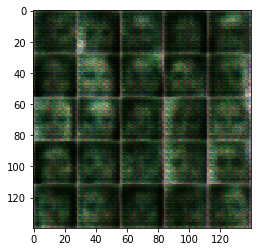

Epoch 1/1... Discriminator Loss: 0.8951... Generator Loss: 1.2231
Epoch 1/1... Discriminator Loss: 1.5866... Generator Loss: 0.4590
Epoch 1/1... Discriminator Loss: 0.6623... Generator Loss: 1.5676
Epoch 1/1... Discriminator Loss: 1.0143... Generator Loss: 1.1302
Epoch 1/1... Discriminator Loss: 1.7345... Generator Loss: 0.4161
Epoch 1/1... Discriminator Loss: 1.0823... Generator Loss: 2.1701
Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 0.5570
Epoch 1/1... Discriminator Loss: 1.4736... Generator Loss: 3.1462
Epoch 1/1... Discriminator Loss: 0.6618... Generator Loss: 2.1621
Epoch 1/1... Discriminator Loss: 1.5772... Generator Loss: 0.4787


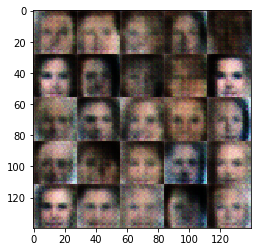

Epoch 1/1... Discriminator Loss: 1.0525... Generator Loss: 2.8916
Epoch 1/1... Discriminator Loss: 0.7754... Generator Loss: 1.4895
Epoch 1/1... Discriminator Loss: 1.0057... Generator Loss: 1.3441
Epoch 1/1... Discriminator Loss: 1.2400... Generator Loss: 0.9404
Epoch 1/1... Discriminator Loss: 1.2318... Generator Loss: 0.8296
Epoch 1/1... Discriminator Loss: 0.9088... Generator Loss: 1.3688
Epoch 1/1... Discriminator Loss: 0.7421... Generator Loss: 1.4909
Epoch 1/1... Discriminator Loss: 1.2712... Generator Loss: 1.5088
Epoch 1/1... Discriminator Loss: 1.0854... Generator Loss: 1.6053
Epoch 1/1... Discriminator Loss: 1.1745... Generator Loss: 0.8718


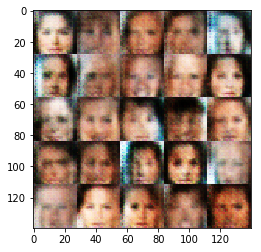

Epoch 1/1... Discriminator Loss: 1.1071... Generator Loss: 1.1933
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 2.4899
Epoch 1/1... Discriminator Loss: 1.4706... Generator Loss: 0.5525
Epoch 1/1... Discriminator Loss: 1.6441... Generator Loss: 0.4905
Epoch 1/1... Discriminator Loss: 1.2663... Generator Loss: 0.7566
Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 0.8782
Epoch 1/1... Discriminator Loss: 1.1868... Generator Loss: 1.1133
Epoch 1/1... Discriminator Loss: 1.1725... Generator Loss: 1.1510
Epoch 1/1... Discriminator Loss: 1.1263... Generator Loss: 1.1979
Epoch 1/1... Discriminator Loss: 1.3298... Generator Loss: 0.7047


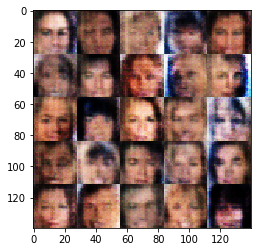

Epoch 1/1... Discriminator Loss: 0.9753... Generator Loss: 1.2852
Epoch 1/1... Discriminator Loss: 1.0597... Generator Loss: 1.0075
Epoch 1/1... Discriminator Loss: 1.3184... Generator Loss: 0.6884
Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 1.0725
Epoch 1/1... Discriminator Loss: 1.2460... Generator Loss: 1.2146
Epoch 1/1... Discriminator Loss: 1.2251... Generator Loss: 0.8738
Epoch 1/1... Discriminator Loss: 1.1602... Generator Loss: 1.0460
Epoch 1/1... Discriminator Loss: 1.7301... Generator Loss: 0.3544
Epoch 1/1... Discriminator Loss: 1.2445... Generator Loss: 0.9882
Epoch 1/1... Discriminator Loss: 1.0154... Generator Loss: 1.0395


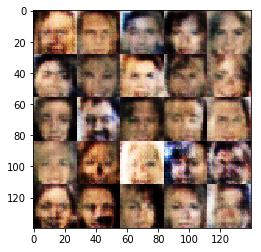

Epoch 1/1... Discriminator Loss: 1.1438... Generator Loss: 1.7572
Epoch 1/1... Discriminator Loss: 1.0166... Generator Loss: 1.0320
Epoch 1/1... Discriminator Loss: 0.9467... Generator Loss: 1.2062
Epoch 1/1... Discriminator Loss: 1.1846... Generator Loss: 0.8635
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.6305
Epoch 1/1... Discriminator Loss: 1.1189... Generator Loss: 1.2112
Epoch 1/1... Discriminator Loss: 0.9784... Generator Loss: 1.6420
Epoch 1/1... Discriminator Loss: 1.1243... Generator Loss: 1.2428
Epoch 1/1... Discriminator Loss: 1.0587... Generator Loss: 0.9463
Epoch 1/1... Discriminator Loss: 0.9195... Generator Loss: 2.1340


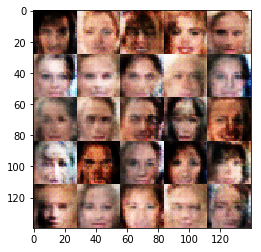

Epoch 1/1... Discriminator Loss: 1.0922... Generator Loss: 1.8557
Epoch 1/1... Discriminator Loss: 1.0237... Generator Loss: 0.8967
Epoch 1/1... Discriminator Loss: 1.0342... Generator Loss: 1.3165
Epoch 1/1... Discriminator Loss: 0.9158... Generator Loss: 1.4662
Epoch 1/1... Discriminator Loss: 0.9887... Generator Loss: 1.1328
Epoch 1/1... Discriminator Loss: 1.2731... Generator Loss: 2.1676
Epoch 1/1... Discriminator Loss: 1.6794... Generator Loss: 2.6037
Epoch 1/1... Discriminator Loss: 1.2305... Generator Loss: 1.5325
Epoch 1/1... Discriminator Loss: 1.4790... Generator Loss: 2.9453
Epoch 1/1... Discriminator Loss: 1.0640... Generator Loss: 2.1094


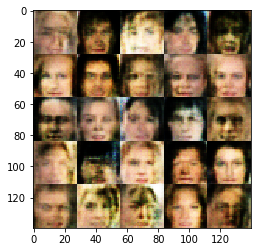

Epoch 1/1... Discriminator Loss: 1.0279... Generator Loss: 1.1888
Epoch 1/1... Discriminator Loss: 1.2008... Generator Loss: 4.1420
Epoch 1/1... Discriminator Loss: 1.2905... Generator Loss: 0.5679
Epoch 1/1... Discriminator Loss: 0.7836... Generator Loss: 1.2417
Epoch 1/1... Discriminator Loss: 0.7049... Generator Loss: 1.9517
Epoch 1/1... Discriminator Loss: 0.6758... Generator Loss: 1.6913
Epoch 1/1... Discriminator Loss: 1.0746... Generator Loss: 1.1199
Epoch 1/1... Discriminator Loss: 0.5273... Generator Loss: 2.3959
Epoch 1/1... Discriminator Loss: 1.1827... Generator Loss: 0.6797
Epoch 1/1... Discriminator Loss: 1.5777... Generator Loss: 0.3957


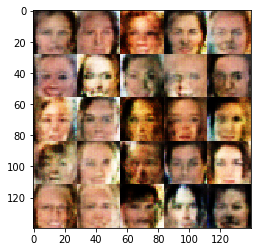

Epoch 1/1... Discriminator Loss: 0.6672... Generator Loss: 1.5000
Epoch 1/1... Discriminator Loss: 1.1424... Generator Loss: 2.3885
Epoch 1/1... Discriminator Loss: 0.7126... Generator Loss: 1.4768
Epoch 1/1... Discriminator Loss: 0.5049... Generator Loss: 2.4042
Epoch 1/1... Discriminator Loss: 0.9414... Generator Loss: 2.8733
Epoch 1/1... Discriminator Loss: 0.8564... Generator Loss: 1.1817
Epoch 1/1... Discriminator Loss: 0.5224... Generator Loss: 2.1310
Epoch 1/1... Discriminator Loss: 0.4909... Generator Loss: 2.9754
Epoch 1/1... Discriminator Loss: 0.6744... Generator Loss: 1.5361
Epoch 1/1... Discriminator Loss: 0.8863... Generator Loss: 2.1600


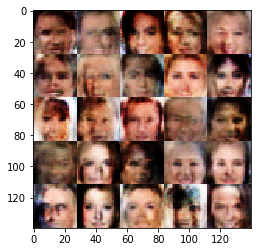

Epoch 1/1... Discriminator Loss: 0.6397... Generator Loss: 3.4629
Epoch 1/1... Discriminator Loss: 0.8276... Generator Loss: 4.1145
Epoch 1/1... Discriminator Loss: 0.9473... Generator Loss: 0.9869
Epoch 1/1... Discriminator Loss: 0.5436... Generator Loss: 2.1260
Epoch 1/1... Discriminator Loss: 1.0496... Generator Loss: 0.8217
Epoch 1/1... Discriminator Loss: 0.4905... Generator Loss: 2.8884
Epoch 1/1... Discriminator Loss: 0.4587... Generator Loss: 2.5482
Epoch 1/1... Discriminator Loss: 0.6879... Generator Loss: 1.7607
Epoch 1/1... Discriminator Loss: 0.5123... Generator Loss: 2.3079
Epoch 1/1... Discriminator Loss: 0.4535... Generator Loss: 2.4582


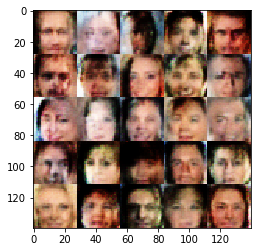

Epoch 1/1... Discriminator Loss: 0.5383... Generator Loss: 2.0271
Epoch 1/1... Discriminator Loss: 1.2118... Generator Loss: 0.6006
Epoch 1/1... Discriminator Loss: 0.6839... Generator Loss: 4.2616
Epoch 1/1... Discriminator Loss: 0.5303... Generator Loss: 3.0412
Epoch 1/1... Discriminator Loss: 0.6495... Generator Loss: 1.6193
Epoch 1/1... Discriminator Loss: 0.4637... Generator Loss: 3.1111
Epoch 1/1... Discriminator Loss: 0.5123... Generator Loss: 2.0339
Epoch 1/1... Discriminator Loss: 0.5670... Generator Loss: 4.2416
Epoch 1/1... Discriminator Loss: 0.3863... Generator Loss: 4.4420
Epoch 1/1... Discriminator Loss: 0.5884... Generator Loss: 1.9895


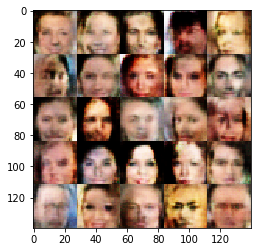

Epoch 1/1... Discriminator Loss: 0.4374... Generator Loss: 3.2234
Epoch 1/1... Discriminator Loss: 0.5513... Generator Loss: 5.8609
Epoch 1/1... Discriminator Loss: 0.6685... Generator Loss: 1.4204
Epoch 1/1... Discriminator Loss: 0.4235... Generator Loss: 2.6990
Epoch 1/1... Discriminator Loss: 1.6244... Generator Loss: 6.9741
Epoch 1/1... Discriminator Loss: 1.5984... Generator Loss: 2.1929
Epoch 1/1... Discriminator Loss: 1.1290... Generator Loss: 0.7115
Epoch 1/1... Discriminator Loss: 0.5064... Generator Loss: 2.7013
Epoch 1/1... Discriminator Loss: 0.4078... Generator Loss: 3.2309
Epoch 1/1... Discriminator Loss: 0.9130... Generator Loss: 0.9713


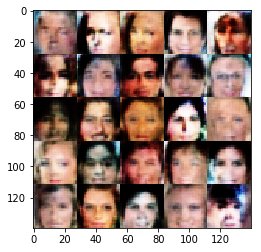

Epoch 1/1... Discriminator Loss: 0.4299... Generator Loss: 4.1411
Epoch 1/1... Discriminator Loss: 0.3808... Generator Loss: 4.0899
Epoch 1/1... Discriminator Loss: 0.4458... Generator Loss: 2.5840
Epoch 1/1... Discriminator Loss: 0.6662... Generator Loss: 4.8752
Epoch 1/1... Discriminator Loss: 0.4867... Generator Loss: 4.7681
Epoch 1/1... Discriminator Loss: 0.4296... Generator Loss: 5.4291
Epoch 1/1... Discriminator Loss: 0.4310... Generator Loss: 2.7006
Epoch 1/1... Discriminator Loss: 0.5562... Generator Loss: 1.9561
Epoch 1/1... Discriminator Loss: 0.3847... Generator Loss: 3.8783
Epoch 1/1... Discriminator Loss: 0.9205... Generator Loss: 0.9889


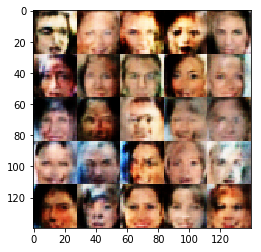

Epoch 1/1... Discriminator Loss: 2.8116... Generator Loss: 0.1458
Epoch 1/1... Discriminator Loss: 1.2949... Generator Loss: 1.0035
Epoch 1/1... Discriminator Loss: 1.2366... Generator Loss: 1.0191
Epoch 1/1... Discriminator Loss: 1.1157... Generator Loss: 0.8307
Epoch 1/1... Discriminator Loss: 1.2907... Generator Loss: 0.6945
Epoch 1/1... Discriminator Loss: 1.1766... Generator Loss: 1.2401
Epoch 1/1... Discriminator Loss: 1.1940... Generator Loss: 0.7159
Epoch 1/1... Discriminator Loss: 1.0512... Generator Loss: 1.6283
Epoch 1/1... Discriminator Loss: 1.2000... Generator Loss: 0.7634
Epoch 1/1... Discriminator Loss: 1.0456... Generator Loss: 1.0385


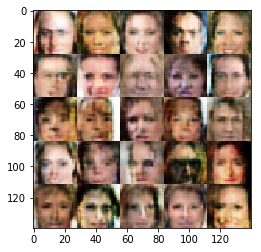

Epoch 1/1... Discriminator Loss: 1.0272... Generator Loss: 1.3351
Epoch 1/1... Discriminator Loss: 1.0862... Generator Loss: 0.7773
Epoch 1/1... Discriminator Loss: 1.1092... Generator Loss: 0.9784
Epoch 1/1... Discriminator Loss: 1.0692... Generator Loss: 0.8516
Epoch 1/1... Discriminator Loss: 1.1155... Generator Loss: 0.9313
Epoch 1/1... Discriminator Loss: 1.0702... Generator Loss: 1.4738
Epoch 1/1... Discriminator Loss: 1.0863... Generator Loss: 0.8770
Epoch 1/1... Discriminator Loss: 1.0130... Generator Loss: 0.9064
Epoch 1/1... Discriminator Loss: 1.0422... Generator Loss: 2.2806
Epoch 1/1... Discriminator Loss: 1.1367... Generator Loss: 0.7574


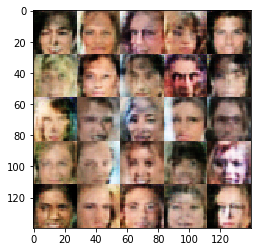

Epoch 1/1... Discriminator Loss: 0.8965... Generator Loss: 1.2316
Epoch 1/1... Discriminator Loss: 1.1182... Generator Loss: 1.8585
Epoch 1/1... Discriminator Loss: 1.0637... Generator Loss: 0.8843
Epoch 1/1... Discriminator Loss: 1.0393... Generator Loss: 1.5744
Epoch 1/1... Discriminator Loss: 1.0973... Generator Loss: 0.8194
Epoch 1/1... Discriminator Loss: 1.4839... Generator Loss: 0.4340
Epoch 1/1... Discriminator Loss: 1.3547... Generator Loss: 0.5218
Epoch 1/1... Discriminator Loss: 1.0343... Generator Loss: 1.0365
Epoch 1/1... Discriminator Loss: 0.9609... Generator Loss: 1.5367
Epoch 1/1... Discriminator Loss: 0.8114... Generator Loss: 1.3814


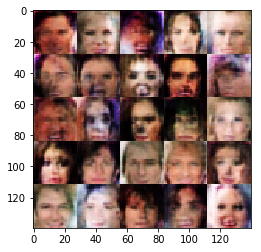

Epoch 1/1... Discriminator Loss: 1.0948... Generator Loss: 0.7665
Epoch 1/1... Discriminator Loss: 0.8191... Generator Loss: 1.2884
Epoch 1/1... Discriminator Loss: 1.0755... Generator Loss: 2.3891
Epoch 1/1... Discriminator Loss: 0.8502... Generator Loss: 1.3846
Epoch 1/1... Discriminator Loss: 1.1306... Generator Loss: 2.3172
Epoch 1/1... Discriminator Loss: 1.5629... Generator Loss: 0.4309
Epoch 1/1... Discriminator Loss: 0.8161... Generator Loss: 1.2412
Epoch 1/1... Discriminator Loss: 1.4583... Generator Loss: 2.5794
Epoch 1/1... Discriminator Loss: 0.9707... Generator Loss: 1.4317
Epoch 1/1... Discriminator Loss: 0.8697... Generator Loss: 1.7113


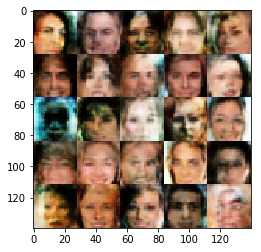

Epoch 1/1... Discriminator Loss: 0.7156... Generator Loss: 1.6163
Epoch 1/1... Discriminator Loss: 0.9816... Generator Loss: 0.8560
Epoch 1/1... Discriminator Loss: 0.6230... Generator Loss: 3.5057
Epoch 1/1... Discriminator Loss: 0.9395... Generator Loss: 0.9335
Epoch 1/1... Discriminator Loss: 1.0559... Generator Loss: 2.7231
Epoch 1/1... Discriminator Loss: 0.6234... Generator Loss: 3.7991
Epoch 1/1... Discriminator Loss: 1.0759... Generator Loss: 0.7786
Epoch 1/1... Discriminator Loss: 1.1689... Generator Loss: 0.7532
Epoch 1/1... Discriminator Loss: 0.5356... Generator Loss: 2.7686
Epoch 1/1... Discriminator Loss: 0.5600... Generator Loss: 1.8585


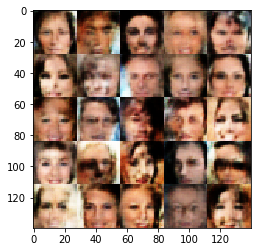

Epoch 1/1... Discriminator Loss: 0.4339... Generator Loss: 2.9953
Epoch 1/1... Discriminator Loss: 0.8222... Generator Loss: 1.6089
Epoch 1/1... Discriminator Loss: 0.5425... Generator Loss: 2.6239
Epoch 1/1... Discriminator Loss: 0.9934... Generator Loss: 0.8937
Epoch 1/1... Discriminator Loss: 0.8935... Generator Loss: 1.1699
Epoch 1/1... Discriminator Loss: 0.5886... Generator Loss: 2.3543
Epoch 1/1... Discriminator Loss: 0.4120... Generator Loss: 3.0481
Epoch 1/1... Discriminator Loss: 0.5532... Generator Loss: 1.7820
Epoch 1/1... Discriminator Loss: 0.5968... Generator Loss: 3.4685
Epoch 1/1... Discriminator Loss: 0.5062... Generator Loss: 4.2718


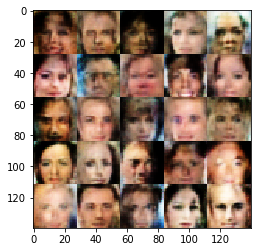

Epoch 1/1... Discriminator Loss: 0.7421... Generator Loss: 1.3416
Epoch 1/1... Discriminator Loss: 0.4248... Generator Loss: 2.7318
Epoch 1/1... Discriminator Loss: 0.9770... Generator Loss: 0.8896
Epoch 1/1... Discriminator Loss: 0.9572... Generator Loss: 1.9140
Epoch 1/1... Discriminator Loss: 0.7952... Generator Loss: 1.9127
Epoch 1/1... Discriminator Loss: 0.7286... Generator Loss: 1.4707
Epoch 1/1... Discriminator Loss: 0.5648... Generator Loss: 1.8737
Epoch 1/1... Discriminator Loss: 0.9554... Generator Loss: 0.9912
Epoch 1/1... Discriminator Loss: 0.6766... Generator Loss: 2.3600
Epoch 1/1... Discriminator Loss: 0.4837... Generator Loss: 2.5875


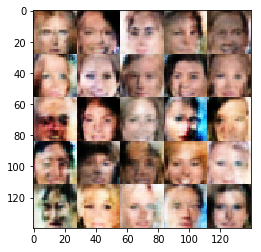

Epoch 1/1... Discriminator Loss: 0.4715... Generator Loss: 4.5006
Epoch 1/1... Discriminator Loss: 0.5804... Generator Loss: 2.6739
Epoch 1/1... Discriminator Loss: 0.4726... Generator Loss: 2.3618
Epoch 1/1... Discriminator Loss: 0.6365... Generator Loss: 1.5443
Epoch 1/1... Discriminator Loss: 0.6521... Generator Loss: 1.4520
Epoch 1/1... Discriminator Loss: 0.5733... Generator Loss: 2.8943
Epoch 1/1... Discriminator Loss: 0.4685... Generator Loss: 2.2869
Epoch 1/1... Discriminator Loss: 0.5377... Generator Loss: 1.9200
Epoch 1/1... Discriminator Loss: 0.4345... Generator Loss: 3.1369
Epoch 1/1... Discriminator Loss: 1.8864... Generator Loss: 3.6385


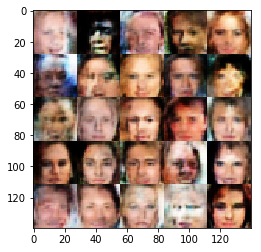

Epoch 1/1... Discriminator Loss: 0.6584... Generator Loss: 1.6245
Epoch 1/1... Discriminator Loss: 0.5434... Generator Loss: 1.9506
Epoch 1/1... Discriminator Loss: 0.4087... Generator Loss: 3.3406
Epoch 1/1... Discriminator Loss: 0.4952... Generator Loss: 4.8579
Epoch 1/1... Discriminator Loss: 0.4233... Generator Loss: 3.3515
Epoch 1/1... Discriminator Loss: 0.9071... Generator Loss: 1.0578
Epoch 1/1... Discriminator Loss: 0.9371... Generator Loss: 1.1309
Epoch 1/1... Discriminator Loss: 0.5017... Generator Loss: 2.5904
Epoch 1/1... Discriminator Loss: 0.6329... Generator Loss: 1.5450
Epoch 1/1... Discriminator Loss: 0.5781... Generator Loss: 1.9241


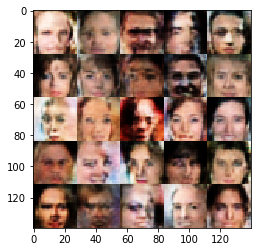

Epoch 1/1... Discriminator Loss: 1.0994... Generator Loss: 0.7114
Epoch 1/1... Discriminator Loss: 0.7265... Generator Loss: 1.3181
Epoch 1/1... Discriminator Loss: 0.5644... Generator Loss: 1.9459
Epoch 1/1... Discriminator Loss: 0.4714... Generator Loss: 2.5195
Epoch 1/1... Discriminator Loss: 0.8896... Generator Loss: 1.0155
Epoch 1/1... Discriminator Loss: 0.4236... Generator Loss: 3.0138
Epoch 1/1... Discriminator Loss: 0.6563... Generator Loss: 1.6701
Epoch 1/1... Discriminator Loss: 0.5955... Generator Loss: 2.8676
Epoch 1/1... Discriminator Loss: 1.4696... Generator Loss: 0.5076
Epoch 1/1... Discriminator Loss: 0.9083... Generator Loss: 1.0035


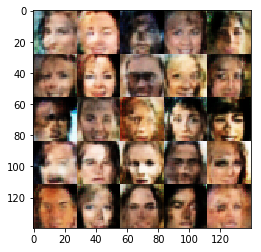

Epoch 1/1... Discriminator Loss: 0.3766... Generator Loss: 5.4919
Epoch 1/1... Discriminator Loss: 0.5825... Generator Loss: 1.8179
Epoch 1/1... Discriminator Loss: 1.7426... Generator Loss: 2.9370
Epoch 1/1... Discriminator Loss: 0.5678... Generator Loss: 2.3167
Epoch 1/1... Discriminator Loss: 0.6195... Generator Loss: 3.3451
Epoch 1/1... Discriminator Loss: 0.8228... Generator Loss: 1.8075
Epoch 1/1... Discriminator Loss: 0.3982... Generator Loss: 3.5476
Epoch 1/1... Discriminator Loss: 0.5281... Generator Loss: 2.0578
Epoch 1/1... Discriminator Loss: 0.6113... Generator Loss: 1.8328
Epoch 1/1... Discriminator Loss: 0.9156... Generator Loss: 1.0270


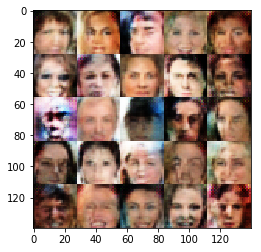

Epoch 1/1... Discriminator Loss: 1.1479... Generator Loss: 0.8259
Epoch 1/1... Discriminator Loss: 0.4597... Generator Loss: 3.8581
Epoch 1/1... Discriminator Loss: 0.6100... Generator Loss: 1.6546
Epoch 1/1... Discriminator Loss: 0.4848... Generator Loss: 2.3566
Epoch 1/1... Discriminator Loss: 0.6022... Generator Loss: 2.0296
Epoch 1/1... Discriminator Loss: 0.7030... Generator Loss: 1.4395
Epoch 1/1... Discriminator Loss: 0.8690... Generator Loss: 1.0981
Epoch 1/1... Discriminator Loss: 0.8047... Generator Loss: 1.4628
Epoch 1/1... Discriminator Loss: 0.5752... Generator Loss: 2.4600
Epoch 1/1... Discriminator Loss: 0.5903... Generator Loss: 2.5586


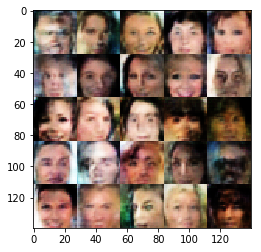

Epoch 1/1... Discriminator Loss: 0.9813... Generator Loss: 0.8507
Epoch 1/1... Discriminator Loss: 0.5812... Generator Loss: 1.7646
Epoch 1/1... Discriminator Loss: 0.7454... Generator Loss: 2.4417
Epoch 1/1... Discriminator Loss: 0.6089... Generator Loss: 1.7600
Epoch 1/1... Discriminator Loss: 0.6813... Generator Loss: 3.2636
Epoch 1/1... Discriminator Loss: 0.6008... Generator Loss: 2.5580
Epoch 1/1... Discriminator Loss: 1.0140... Generator Loss: 3.0421
Epoch 1/1... Discriminator Loss: 0.5150... Generator Loss: 3.4597
Epoch 1/1... Discriminator Loss: 0.7350... Generator Loss: 1.2158
Epoch 1/1... Discriminator Loss: 0.5563... Generator Loss: 1.9071


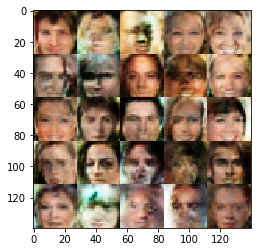

Epoch 1/1... Discriminator Loss: 0.5021... Generator Loss: 2.5793
Epoch 1/1... Discriminator Loss: 2.0894... Generator Loss: 0.3011
Epoch 1/1... Discriminator Loss: 1.4392... Generator Loss: 2.5168
Epoch 1/1... Discriminator Loss: 0.8715... Generator Loss: 1.1344
Epoch 1/1... Discriminator Loss: 0.7389... Generator Loss: 1.5122
Epoch 1/1... Discriminator Loss: 0.8255... Generator Loss: 2.4000
Epoch 1/1... Discriminator Loss: 0.7408... Generator Loss: 1.8704
Epoch 1/1... Discriminator Loss: 0.8614... Generator Loss: 1.0156
Epoch 1/1... Discriminator Loss: 0.5157... Generator Loss: 2.1937
Epoch 1/1... Discriminator Loss: 0.8200... Generator Loss: 2.2235


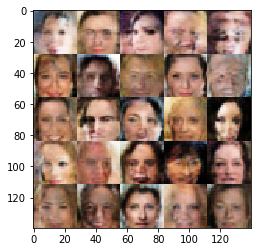

Epoch 1/1... Discriminator Loss: 0.7939... Generator Loss: 1.1766
Epoch 1/1... Discriminator Loss: 0.8783... Generator Loss: 1.0221
Epoch 1/1... Discriminator Loss: 0.5030... Generator Loss: 2.7242
Epoch 1/1... Discriminator Loss: 0.8888... Generator Loss: 1.0417
Epoch 1/1... Discriminator Loss: 0.7217... Generator Loss: 1.3706
Epoch 1/1... Discriminator Loss: 0.8207... Generator Loss: 1.1749
Epoch 1/1... Discriminator Loss: 0.4680... Generator Loss: 2.4232
Epoch 1/1... Discriminator Loss: 0.5924... Generator Loss: 1.6360
Epoch 1/1... Discriminator Loss: 0.6520... Generator Loss: 2.6214
Epoch 1/1... Discriminator Loss: 1.2255... Generator Loss: 3.3647


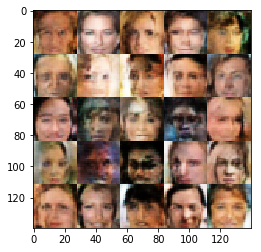

Epoch 1/1... Discriminator Loss: 0.7180... Generator Loss: 1.9066
Epoch 1/1... Discriminator Loss: 0.7060... Generator Loss: 1.4318
Epoch 1/1... Discriminator Loss: 0.5320... Generator Loss: 2.1816
Epoch 1/1... Discriminator Loss: 0.4986... Generator Loss: 3.1489
Epoch 1/1... Discriminator Loss: 0.8515... Generator Loss: 1.0987
Epoch 1/1... Discriminator Loss: 0.8064... Generator Loss: 1.2044
Epoch 1/1... Discriminator Loss: 1.2493... Generator Loss: 0.6648
Epoch 1/1... Discriminator Loss: 0.6477... Generator Loss: 2.0076
Epoch 1/1... Discriminator Loss: 0.4657... Generator Loss: 3.2125
Epoch 1/1... Discriminator Loss: 0.6710... Generator Loss: 1.5430


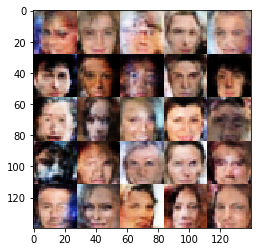

Epoch 1/1... Discriminator Loss: 0.5423... Generator Loss: 1.9122
Epoch 1/1... Discriminator Loss: 0.4045... Generator Loss: 3.3691
Epoch 1/1... Discriminator Loss: 0.6558... Generator Loss: 1.5633
Epoch 1/1... Discriminator Loss: 0.4786... Generator Loss: 2.4464
Epoch 1/1... Discriminator Loss: 1.9061... Generator Loss: 0.3295
Epoch 1/1... Discriminator Loss: 1.2457... Generator Loss: 0.6402
Epoch 1/1... Discriminator Loss: 0.5974... Generator Loss: 1.9989
Epoch 1/1... Discriminator Loss: 0.7120... Generator Loss: 1.3615
Epoch 1/1... Discriminator Loss: 0.8904... Generator Loss: 1.0299
Epoch 1/1... Discriminator Loss: 0.9004... Generator Loss: 1.0102


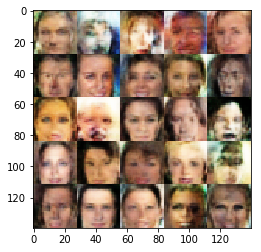

Epoch 1/1... Discriminator Loss: 0.4652... Generator Loss: 2.7090
Epoch 1/1... Discriminator Loss: 0.4724... Generator Loss: 2.9904
Epoch 1/1... Discriminator Loss: 0.9985... Generator Loss: 0.8172
Epoch 1/1... Discriminator Loss: 0.4386... Generator Loss: 2.8686
Epoch 1/1... Discriminator Loss: 0.6375... Generator Loss: 1.6611
Epoch 1/1... Discriminator Loss: 1.0756... Generator Loss: 2.1377
Epoch 1/1... Discriminator Loss: 0.7286... Generator Loss: 1.4468
Epoch 1/1... Discriminator Loss: 0.8343... Generator Loss: 1.0908
Epoch 1/1... Discriminator Loss: 0.8427... Generator Loss: 1.0883
Epoch 1/1... Discriminator Loss: 0.7930... Generator Loss: 1.1764


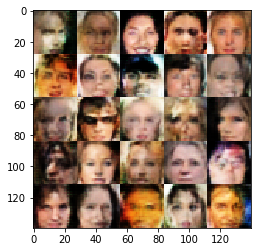

Epoch 1/1... Discriminator Loss: 0.9202... Generator Loss: 1.2577
Epoch 1/1... Discriminator Loss: 0.5334... Generator Loss: 2.2079
Epoch 1/1... Discriminator Loss: 0.6788... Generator Loss: 1.4714
Epoch 1/1... Discriminator Loss: 0.4865... Generator Loss: 3.1867
Epoch 1/1... Discriminator Loss: 0.7466... Generator Loss: 1.3087
Epoch 1/1... Discriminator Loss: 0.5219... Generator Loss: 2.4136


In [15]:
batch_size = 64
z_dim = 112
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.